# Sign Language Detection using Action Recognition with Python | LSTM Deep Learning Model

To improve a sign language model, we leverage action detection. Specifically, we use a **key-point detection model** to build a sequence of key-points which can then be passed to an action detection model to decode sign language. As part of the model building process, we'll be using `Tensorflow` and `Keras` to build a deep neural network that leverages LSTM layers to handle the sequence of key-points.

**Main Objective:**
Real-time sign language detection using sequences

This report is divided into the following parts:

1. Extract MediaPipe holistic key-points

2. Build a sign language model using Action Detection powered by LSTM layers (train LSTM DL model)

3. Make real-time predictions for sign language using video sequences in OpenCV

![sign-lang](sign-language-character-gesture.jpg "Sign-Language Gestures")

## Import and Install Dependencies/Packages

In [1]:
%pip install tensorflow

# to leverage dedicated GPU (NVIDIA)
%pip install tensorflow-gpu

# to work with webcam
%pip install opencv-python

# to extract key-points (Link: https://google.github.io/mediapipe/solutions/holistic.html)
%pip install mediapipe

# for train-test split and evaluation metrics
%pip install sklearn

# to visualize images better
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2 #openCV
import numpy as np #to work with array structures
import os #to work with file paths
from matplotlib import pyplot as plt
import time #to take a sleep between each frame
import mediapipe as mp

## Extract Key-points

In [3]:
mp_holistic = mp.solutions.holistic     # holistic model
mp_drawing = mp.solutions.drawing_utils # drawing utilities: to draw key-points on face

In [4]:
# function to make detection
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert color space from BGR to RGB
    image.flags.writeable = False                  # image is no longer writeable
    results = model.process(image)                 # predictions
    image.flags.writeable = True                   # image is writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # convert color space from RGB to BGR
    return image, results

In [5]:
# grab landmark results & render on current image (doesn't return image) by applying formatting for face, pose and hand
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                              mp_drawing.DrawingSpec(color=(255, 255, 86), thickness=1, circle_radius=1),
                              mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=1, circle_radius=1)) # render face connections
    
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(255, 86, 170), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(86, 255, 255), thickness=2, circle_radius=2)) # render pose connections
    
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(0, 127, 255), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=2, circle_radius=2)) # render left hand connections
    
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=2, circle_radius=2)) # render right hand connections    

In [6]:
# setup video capture looping through each frame

cap = cv2.VideoCapture(0) #to access webcam device

# set mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    while cap.isOpened():     # loop through all frames

        # read frames
        ret, frame = cap.read()

        # make detections
        image, results = mediapipe_detection(frame, holistic)
       
        # draw formatted landmarks
        draw_styled_landmarks(image, results)
        
        # show image on screen
        cv2.imshow('OpenCV Feed', image)

        # break gracefully if hit 'q' on keyboard
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()           # release webcam
    cv2.destroyAllWindows() # close down all frames

**Landmark Values:**
- Face and hand landmark models will return no values if nothing is detected.
- Pose model will return landmarks but the visibility value inside each landmark will be low.

In [7]:
len(results.left_hand_landmarks.landmark) # check no. of handmarks on left hand 

21

In [8]:
results

mediapipe.python.solution_base.SolutionOutputs

In [9]:
draw_styled_landmarks(frame, results)

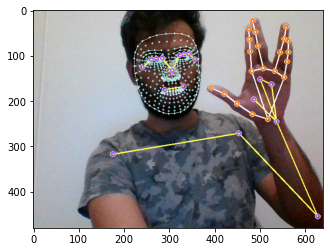

In [10]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) # visualize last frame after color conversion & applying landmarks

## Extract Key-point Values

In [11]:
results.pose_landmarks # extract last result

landmark {
  x: 0.48089370131492615
  y: 0.2791220247745514
  z: -0.5791358947753906
  visibility: 0.9999977350234985
}
landmark {
  x: 0.5047296285629272
  y: 0.20661160349845886
  z: -0.5011570453643799
  visibility: 0.999995768070221
}
landmark {
  x: 0.5203796625137329
  y: 0.20390209555625916
  z: -0.5008159875869751
  visibility: 0.9999962449073792
}
landmark {
  x: 0.5362855195999146
  y: 0.20163819193840027
  z: -0.5002275705337524
  visibility: 0.9999964237213135
}
landmark {
  x: 0.4460744857788086
  y: 0.2188536375761032
  z: -0.5250207185745239
  visibility: 0.9999951124191284
}
landmark {
  x: 0.4259131848812103
  y: 0.2233116179704666
  z: -0.5243113040924072
  visibility: 0.9999946355819702
}
landmark {
  x: 0.40787631273269653
  y: 0.22907106578350067
  z: -0.524577796459198
  visibility: 0.9999933242797852
}
landmark {
  x: 0.5591293573379517
  y: 0.22646918892860413
  z: -0.0850009098649025
  visibility: 0.9999964237213135
}
landmark {
  x: 0.37769633531570435
  y: 0.

The input data used for this action detection model is a series of 30 arrays each of which contains 1662 values (30, 1662). Each of the 30 arrays represents the landmark values (1662 values) from a single frame.

In [12]:
# extract kepypoints, convert into numpy array & concatenate components
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() \
    if results.pose_landmarks else np.zeros(33*4)
    # flatten to reshape into single array required for passing to LSTM model
    # error handling for no landmark results
    
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() \
    if results.face_landmarks else np.zeros(468*3)
    
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() \
    if results.left_hand_landmarks else np.zeros(21*3)
    
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() \
    if results.right_hand_landmarks else np.zeros(21*3)
    
    return np.concatenate([pose, face, lh, rh])

In [13]:
extract_keypoints(results)

array([ 0.4808937 ,  0.27912202, -0.57913589, ...,  0.        ,
        0.        ,  0.        ])

In [14]:
extract_keypoints(results).shape

(1662,)

## Folder Setup for Collection

We will be using 30 frames, i.e., effectively 30 different sets of proceeding key-points to be able to classify an action. In nutshell, we use a sequence of data rather than a single frame for detection. So, we will be collecting 30 videos per action (hello, thanks, iloveyou) where each video will be containing 30 frames of data. Each of these frames will contain 1662 landmark values.

In [15]:
data_path = os.path.join('MP Data') # path for exported data (numpy arrays)
actions = np.array(['hello', 'thanks', 'iloveyou']) # actions to be detected
no_sequences = 30 # 30 videos of data to be collected for each action
sequence_length = 30 # each video of 30 frames in length

In [16]:
# create folders for each action to store data
for action in actions:
    for sequence in range(no_sequences):
        try: # to handle error in case directory exists already
            os.makedirs(os.path.join(data_path, action, str(sequence)))
        except:
            pass

## Collect Key-point Values for Train & Test

We apply collection breaks between each one of the frames being collected. Having breaks between each sequence collection allows us to reset and reposition ourselves (the subject of image) in order to collect each action from start to finish.

In [17]:
# setup video capture looping through each frame
cap = cv2.VideoCapture(0) #to access webcam device

# set mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    #NEW LOOP
    for action in actions: # loop through actions
        for sequence in range(no_sequences): # loop through sequences/videos
            for frame_no in range(sequence_length): # loop through video length 

                # read frames
                ret, frame = cap.read()

                # make detections
                image, results = mediapipe_detection(frame, holistic)

                # draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW
                # collection break/wait logic
                if frame_no == 0:
                    cv2.putText(image, 'COLLECTING NOW...', (120, 200), 
                                cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for Action: {} & Video: {}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image) # show image on screen
                    cv2.waitKey(1500) # break is 1.5 seconds
                else:
                    cv2.putText(image, 'Collecting frames for Action: {} & Video: {}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image) # show image on screen
                
                # NEW extract key-points
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(data_path, action, str(sequence), str(frame_no))
                np.save(npy_path, keypoints)
                
                # break gracefully if hit 'q' on keyboard
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    cap.release()           # release webcam
    cv2.destroyAllWindows() # close down all frames

## Pre-process Data and Create Lables & Features

We will first import the following additional dependencies :
  - `train_test_split` from scikit learn: to allow us to create a training and testing partition
  - `to_categorical` function form keras utility : to allow us to help with our labels

In [18]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

Now, we are going to create a label map. For this, we are going to create a label array or a label dictionary to represent each one of our different actions.

In [19]:
label_map = {label:num for num, label in enumerate(actions)}

Next, we will be bringing all our data together and structure it. So, we will be creating one big array which actually contains all of our data, effectively, 90 arrays with 30 frames in each one of those arrays with 1662 values which represent our key points in each.

In [20]:
sequences, labels = [], [] # create two blank arrays
for action in actions:
    for sequence in range(no_sequences):
        window = [] # represent all different frames for a particular sequence
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(data_path, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [21]:
np.array(sequences).shape

(90, 30, 1662)

In [22]:
np.array(labels).shape

(90,)

In [23]:
X = np.array(sequences)
y = to_categorical(labels).astype(int) # one-hot-encoding

In [24]:
# perform train-test partition
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)

## Build & Train LSTM Neural Network

First we will be importing following four dependencies:
- Sequential modeling
- LSTM layer
- Dense layer
- TensorBoard

In [25]:
from tensorflow.keras.models import Sequential 
# build a sequential neural network

from tensorflow.keras.layers import LSTM, Dense 
# gives a temporal component for NN & allows performing action detection
# Dense layer is a normal fully connected layer

from tensorflow.keras.callbacks import TensorBoard 
# perform logging inside TensorBoard web app to trace & monitor model during training

Next, we will be creating a log directory and set up our TensorBoard callbacks to monitor our neural network training and its accuracy as its being trained.

In [26]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

Now, we will be building up our neural network architecture.

In [27]:
model = Sequential() # instantiating the model, specifically the Sequential API

# add 3 set of LSTM layers
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662))) # 30 frames per prediction multiplied by 1662 values
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu')) 
#return_sequences=False as next layer is Dense layer, so we require to not return the sequences to that layer

# add 3 fully connected (Dense) layers
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax')) # actions layer
# 'softmax' returns values with a probability between 0 & 1 so that the sum of all add up to 1. The highest value represents
# the action that's been detected

**IMPORTANT NOTE** : *Why are we using this type of neural network with MediaPipe + LSTM Layers ?*

State-of-the-art models that are currently out there tend to use a number of CNN layers followed by a number of LSTM layers, specifically some of them using a pre-trained mobile net followed a number of LSTM layers. But in our case, when we trained with a similar number of sequences, the level of accuracy produced was nowhere near useful. Therefore, the MediaPipe + LSTM layers approach was chosen because of the folloing three main reasons :

1. *Less data required* : We needed less data to produce a hyper accurate model.
2. *Faster to train* : It was a much denser neural network. So, instead of having 30-40 million parameters in the neural network, we had about half a million parameters, which means it was going to be way faster to go ahead and train the particular model.
3. *Faster detections* : Because the neural network was much simpler, it is going to be hugely faster when it comes to detecting in real-time.

Now, we are going to compile our model and fit it.

In [28]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# 'Adam' is the optimizer chosen
# 'categorical_crossentropy' is the loss function used for multi-class classification model
# metrics have been specified to track our accuracy as we train

In the meantime when we train our model, to view the Tensorflow logs in TensorBoard we do the following steps:
- Open CMD or Anaconda CMD
- Navigate to the log directory (training folder)
- Type: `tensorboard ==logdir=.` and press Enter

In case TensorBoard doesn't open up, we need to activate it first by doing the following steps:
- Open Anaconda CMD
- Type: `tensorboard --logdir="D:/Personal Projects/Logs/train/"` and press Enter

If all goes correct, we will get a link like: http://localhost:6006/, which we need to copy and open in any web browser. We can then see our model running and check performance of categorical training accuracy. Also, we can take a look at our neural network architecture, time series data etc.

In [29]:
# fit and train model
model.fit(X_train, y_train, epochs=1000, callbacks=[tb_callback])
# 1000 epochs may be high for training with such a low amount of data. So, training may be stopped early if accuracy is
# acceptable and loss has stopped consistently decreasing.

Epoch 1/1000
3/3 [==============================] - 3s 442ms/step - loss: 2.8160 - categorical_accuracy: 0.2706
Epoch 2/1000
3/3 [==============================] - 0s 62ms/step - loss: 2.5231 - categorical_accuracy: 0.4353
Epoch 3/1000
3/3 [==============================] - 0s 59ms/step - loss: 3.4703 - categorical_accuracy: 0.3059
Epoch 4/1000
3/3 [==============================] - 0s 60ms/step - loss: 2.5688 - categorical_accuracy: 0.4235
Epoch 5/1000
3/3 [==============================] - 0s 59ms/step - loss: 2.9769 - categorical_accuracy: 0.3529
Epoch 6/1000
3/3 [==============================] - 0s 59ms/step - loss: 3.7869 - categorical_accuracy: 0.2706
Epoch 7/1000
3/3 [==============================] - 0s 60ms/step - loss: 1.4894 - categorical_accuracy: 0.3647
Epoch 8/1000
3/3 [==============================] - 0s 61ms/step - loss: 2.8847 - categorical_accuracy: 0.3765
Epoch 9/1000
3/3 [==============================] - 0s 59ms/step - loss: 2.4446 - categorical_accuracy: 0.4353


KeyboardInterrupt: 

Since we already reach a reasonable level of accuracy, we stop the process. Now, to take a look at what our model looks like, we do the following: 

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            442112    
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 596,675
Trainable params: 596,675
Non-trainable params: 0
__________________________________________________

We can see that we have got 3 different LSTM layers followed by the dense layers. Also, we have got a reasonably small no. of parmeters to train, i.e., `596,675` (as opposed to around millions of parameters when using a CNN layer). In our case, where we have less data, this LSTM method works better than CNN method.

## Make Predictions

In [31]:
res = model.predict(X_test)

In [32]:
actions[np.argmax(res[3])]

'hello'

In [33]:
actions[np.argmax(y_test[3])]

'hello'

Comparing the predictions with the actual values, we can see the model is performing pretty well.

## Save Weights

After we have trained our nural network, we will save the values for usage later.

In [34]:
model.save('action.h5')

If we go to the working directory now, we will be able to see the `action.h5` file.

In case we delete our model, we can do the following steps to reload our model:

1. Run: `del model`
2. Go back up to section for model build and run it
3. Then compile it using the compile cell
4. Run: `model.load_weights('action.h5')`

## Model Evaluation

To check how the model is actual performing, we will do performance evaluation using confusion matrices and accuracy scores. A multi-label confusion matrix gives us a confusion matrix for each of the different labels, allowing us to evaluate what is being detected as true positive and a true negative vs. false positive and false negative.

In [35]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [36]:
yhat = model.predict(X_test)

Here, we convert the predictions from their one-hot-encoded representation to categorical labels, e.g., 0,1 or 2 instead of [1,0,0], [0,1,0] or [0,0,1].

In [37]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
multilabel_confusion_matrix(ytrue, yhat)

array([[[2, 0],
        [0, 3]],

       [[4, 0],
        [0, 1]],

       [[4, 0],
        [0, 1]]], dtype=int64)

We get $2\times2$ confusion matrices, wherein all of our values are either in the top-left (TRUE POSITIVES) or in the bottom-right (TRUE NEGATIVES). Now, we pass this to the accuracy score method.

In [38]:
accuracy_score(ytrue, yhat)

1.0

So, we get a 100% accuracy on our test set and this is due to a small test set. So, if we evaluated the model on the training data (which is not an ideal approach), we can visualize the same thing in a broader perspective.

In [39]:
yhat_t = model.predict(X_train)
ytrue_t = np.argmax(y_train, axis=1).tolist()
yhat_t = np.argmax(yhat_t, axis=1).tolist()
multilabel_confusion_matrix(ytrue_t, yhat_t)

array([[[57,  1],
        [ 0, 27]],

       [[56,  0],
        [ 0, 29]],

       [[56,  0],
        [ 1, 28]]], dtype=int64)

As we can see that in this case, the confusion matrix shows a slightly lessser performance. Running through the accuracy score function also gives us a lower value than before.

In [40]:
accuracy_score(ytrue_t, yhat_t)

0.9882352941176471

## Real-time Testing

To perform real-time detection, we will be creating 4 new detection variables:

- `sequence`: to collect the 30 frames in order to be able to generate a prediction
- `sentence`: to concatenate history the detections together
- `predictions`: to append all the predictions to this empty array
- `threshold`: acts like a confidence metric, i.e., we're only going to render results if they're above this value

In order to visualize the probabilities of detected action in real-time, we define a function `prob_viz`.

In [64]:
from scipy import stats

In [65]:
# render the probabilites
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245)] # for coloring of the arrays, one for each action
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60+num*40), (int(prob*100), 90+num*40), colors[num], -1) # drawing a dynamic rectangle
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 1, cv2.LINE_AA)
    return output_frame

So, the action probabilities for a frame would be rendered as shown below:

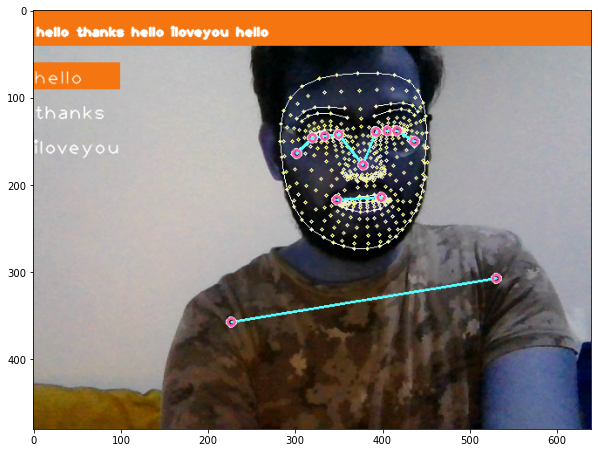

In [66]:
plt.figure(figsize=(10,10))
plt.imshow(prob_viz(res, actions, image, colors))

In [67]:
#1. new detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.7

# setup video capture looping through each frame

cap = cv2.VideoCapture(0) #to access webcam device

# set mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    while cap.isOpened():     # loop through all frames

        # read frames
        ret, frame = cap.read()

        # make detections
        image, results = mediapipe_detection(frame, holistic)
       
        # draw formatted landmarks
        draw_styled_landmarks(image, results)        
#-------------------------------------------------------------------------
        #2. prediction logic
        keypoints = extract_keypoints(results) # extracting the keypoints
        sequence.append(keypoints)
        sequence = sequence[-30:] # grab the last 30 sequences
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0] 
            # expand_dims matches shape of sequence that model expects
            # allows us to pass through one sequence at a time rather than having to pass through a bunch
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))            
#-------------------------------------------------------------------------
        #3. visualisation logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
            # grab last 10 unique predictions to check if they are exactly same in order 
            # to boost stability for action prediction and minimise false detections between two actions
                
                if res[np.argmax(res)] > threshold:
                # check if we've got words in the sentence
                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])
                        
            if len(sentence) > 5:
                sentence = sentence[-5:]
#-------------------------------------------------------------------------                
            #4. visualization probabilites
            image = prob_viz(res, actions, image, colors)
#-------------------------------------------------------------------------

        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 2, cv2.LINE_AA)
                               
        # show image on screen
        cv2.imshow('OpenCV Feed', image)

        # break gracefully if hit 'q' on keyboard
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()           # release webcam
    cv2.destroyAllWindows() # close down all frames

hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
iloveyou
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
i

hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
iloveyou
hello
hello
hello
hello
hello
hello
hell

In [44]:
#cap.release()
#cv2.destroyAllWindows()

In the *prediction logic*, we first extract the keypoints and then append these keypoints to the end of the sequence. From here, we grab the last 30 sets of keypoints, which is going to allow us to get 30 frames for prediction generation. However, since initially we won't be actually having 30 frames, we implement a logic such that the prediction runs only if length of the sequence equals to 30.

In the *sentence logic*, we first check if there are any words in the sentence array. If not, we append the current action to it. If we do, then further we check if the current predicted action doesn't match the last word. If they don't match, we append the current action. Otherwise if they match, we skip the appending in order to prevent duplication. We are doing this because we don't want to double up, as our model is going to be continuously detecting. Therefore, we only want to append the next action if that action is different from the last one. Next, we check if our sentence length is greater than 5 words. If yes, then we grab the last 5 values in order to prevent ending up with a giant array we're trying to render. After this, we continue with the rendering process where we concatenate our sentence array together.

--------------------------------------------------------